In [1]:
import catboost as cat
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.manifold import TSNE

import warnings

warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):

    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))

    plt.figure(figsize=(18,10))
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

**Класс обработки данных**

In [2]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.med_price_by_district = None
        self.total_med_square = None
        self.district_size = None

    def clean(self, df):
        # 1. Пропуски
        df = df[df['Square'].isnull() |
                            (df['Square'] < df['Square'].quantile(.99)) &
                            (df['Square'] > df['Square'].quantile(.01))]
        
        df = df[df['LifeSquare'].isnull() | 
                            (df['LifeSquare'] < df['LifeSquare'].quantile(.99)) &
                            (df['LifeSquare'] > df['LifeSquare'].quantile(.01))]
        
        df = df[df['KitchenSquare'].isnull() |
                            (df['KitchenSquare'] < df['KitchenSquare'].quantile(.99)) &
                            (df['KitchenSquare'] > df['KitchenSquare'].quantile(.01))]


        self.district_size = df['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        
        
        temp_df = df.copy(deep=True)
        temp_df["SQM_Price_byDistrict"] = temp_df.Price / temp_df.Square #Добавляем новую фичу стоимость кв. м. по району
        
        self.total_med_square = temp_df["SQM_Price_byDistrict"].mean()
        self.med_price_by_district = temp_df.groupby(['DistrictId'], as_index=False).agg({'SQM_Price_byDistrict':'mean'})
              
        target_df = df.Price
        df = df.drop(['Price'], axis=1)
        
        return df, target_df
        
    def transform(self, df):

        """Трансформация данных"""
        
        # 2. Выбросы (outliers)
        
        df.loc[df['Rooms'].isin([0, 10, 19]), 'Rooms'] = df['Rooms'].median()
        df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = df['Healthcare_1'].median()
        df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['LifeSquare'].median()
        
        floor_outliers = df[df['Floor'] > df['HouseFloor']].index
        df.loc[floor_outliers, 'Floor'] = df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, 100))
        df.loc[df['HouseYear'] > 2020, 'HouseYear'] = 2020
        
        # 3. Заменяем категориальные свойства (features)
        df = pd.get_dummies(df, columns=["Ecology_2"])
        df = pd.get_dummies(df, columns=["Ecology_3"])
        df = pd.get_dummies(df, columns=["Shops_2"])
        
        df = df.merge(self.district_size, on='DistrictId', how='left')
        
        df = df.merge(self.med_price_by_district, on=['DistrictId'], how='left') #Добавляем фичу стредней стоимости
        df = df.drop(['DistrictId'], axis=1)
        
        #df['Ecology_2_bin'] = df['Ecology_2'].replace({'A':0, 'B':1})
        #df['Ecology_3_bin'] = df['Ecology_3'].replace({'A':0, 'B':1})
        #df['Shops_2_bin'] = df['Shops_2'].replace({'A':0, 'B':1})
        
        return df
        
    def normalise(self, df):    
        scaler = StandardScaler()
        df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
        return df
   # def add_price_feature(self, test_df,)


In [3]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

full_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

house_data_features = ['DistrictId','Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'] #определение нужных свойств


X_test = pd.DataFrame(test_df) # Считываем данные тестового файла
test_id = X_test["Id"]         # Формируем ID для фрейма выходных данных
pred_df = pd.DataFrame()       # Формируем фрейм
pred_df["Id"] = test_id        # Заполняем ID квартир

full_df_X = pd.DataFrame(full_df, columns=house_data_features)
full_df_y = full_df_X.Price

**Производим обработку данных и расчет при помощи RandomForestRegressor**

In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(full_df_X, full_df_y, test_size=0.60, random_state = 42)

# Обработка тренировочных данных
pipe = DataPipeline()
X_train, y_train = pipe.clean(X_train) # чистка
X_train = pipe.transform(X_train)      # трансформация
X_train = pipe.normalise(X_train)      # нормализация


# Обработка валидационных данных
#X_valid, y_valid = pipe.clean(X_valid) # чистка
X_valid = X_valid.drop(['Price'], axis=1)    # Удаляем лишний столцец
X_valid = pipe.transform(X_valid)       # трансформация
X_valid = pipe.normalise(X_valid)       # нормализация
X_valid.loc[(X_valid['SQM_Price_byDistrict'].isnull())] = pipe.total_med_square


# Обработка тестовых данных
X_test = X_test.drop(['Id'], axis=1)    # Удаляем лишний столцец
X_test = pipe.transform(X_test)         # трансформация
X_test = pipe.normalise(X_test)         # нормализация
X_test.loc[(X_test['SQM_Price_byDistrict'].isnull())] = pipe.total_med_square


model = RandomForestRegressor(max_depth=12, n_estimators=500, n_jobs=-1, random_state=39)
model.fit(X_train, y_train)
#y_pred_RF = model.predict(X_train)

RandomForestRegressor(max_depth=12, n_estimators=500, n_jobs=-1,
                      random_state=39)

In [5]:
#X_test.loc[(X_test['SQM_Price_byDistrict'].isnull())] = pipe.total_med_square

y_train_preds = model.predict(X_train)
y_valid_preds = model.predict(X_valid)

y_test_preds = model.predict(X_test)
#pd.DataFrame(y_test_preds)

In [6]:
#X_train

Train R2:	0.947
Test R2:	0.641


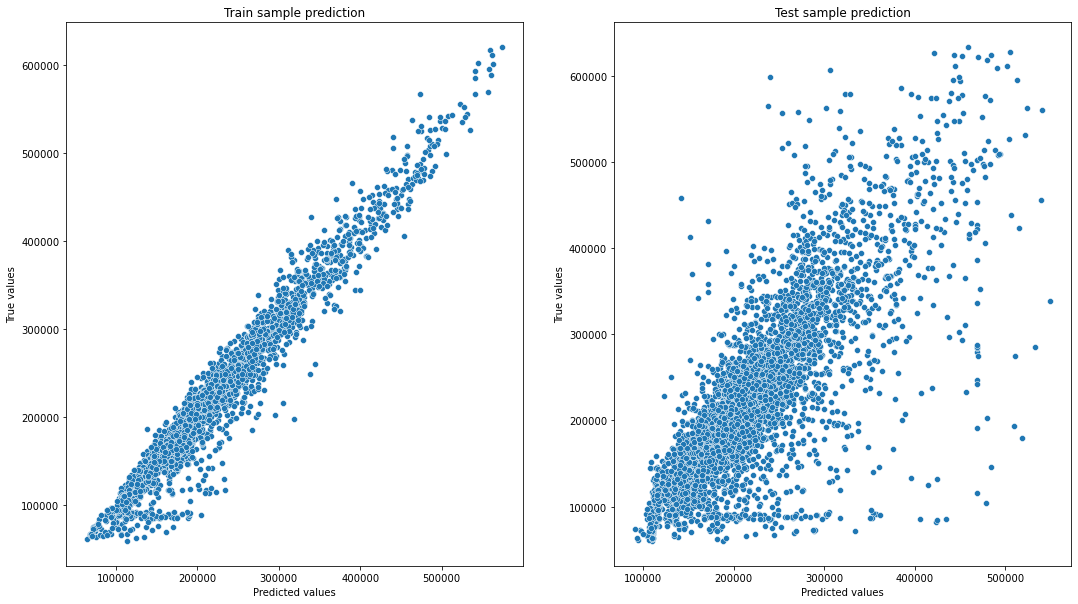

In [7]:
evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

#r2(y_valid, y_pred_RF)
#y_test_preds

**Анализируем вляние/важность фич в выборке**

Добиваемся отсутствия дисбаланса, т.е. сильного превышения важности одной фичи над другими.

In [8]:
feature_importances = pd.DataFrame(zip(X_train.columns, model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)[0:6]

,feature_name,importance
1,Square,0.454468
21,SQM_Price_byDistrict,0.349214
0,Rooms,0.026021
6,HouseYear,0.022378
2,LifeSquare,0.019388
4,Floor,0.017074


**Производим расчет при помощи CatBoostRegressor**

Train R2:	0.87
Test R2:	0.664


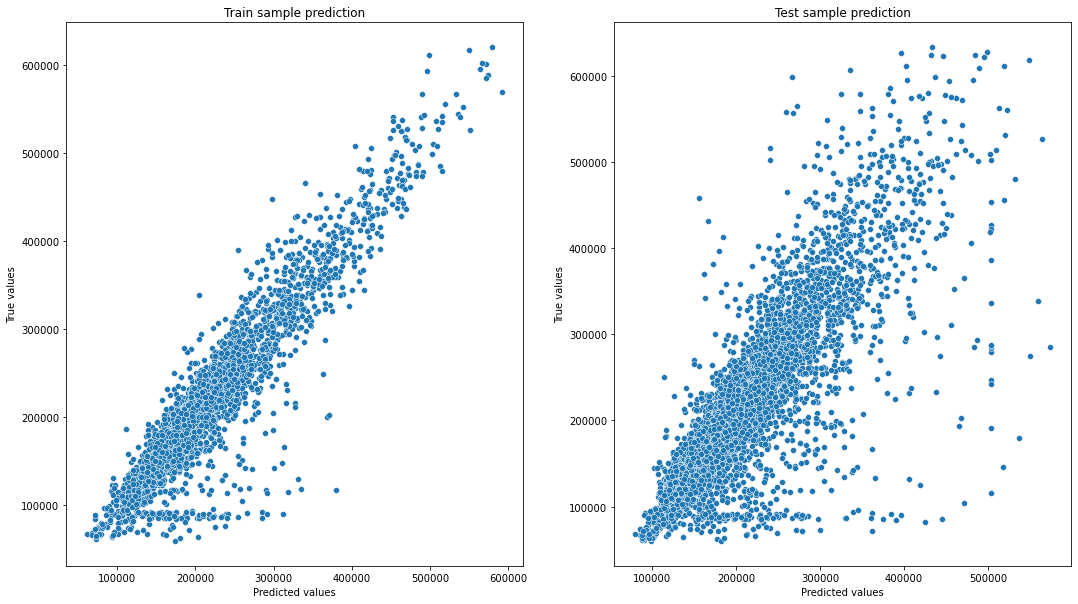

In [9]:
from catboost import CatBoostRegressor
cat = CatBoostRegressor(iterations=500, max_depth=5, learning_rate=0.05, random_seed=1066, logging_level='Silent')
cat.fit(X_train,y_train,verbose=False, plot=False)

y_train_preds = cat.predict(X_train)
y_valid_preds = cat.predict(X_valid)
y_test_preds = cat.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)


**Проверка результатов и сохранение**

In [10]:
pred_df["Price"] = y_test_preds
assert pred_df.shape[0] == 5000, f"Real pred-shape = {pred_df.shape[0]}, Expected pred-shape = 5000"

pred_df.to_csv("./Parunakyan_predictions_.csv", index=False)
pred_df = pd.read_csv("./Parunakyan_predictions_.csv")
pred_df

,Id,Price
0,725,157770.646382
1,15856,186624.644609
2,5480,227832.333877
3,15664,292985.112110
4,14275,139205.852421
...,...,...
4995,8180,239448.280089
4996,4695,133551.661896
4997,5783,301291.405057
4998,4780,193418.409390


**Уменьшение размерности с 21 до 2 тренировочных данных**

In [11]:
tsne = TSNE(n_components=2, learning_rate=20, random_state=42)

X_train_tsne = None
X_train_tsne = tsne.fit_transform(X_train)

print('До:\t{}'.format(X_train.shape))
print('После:\t{}'.format(X_train_tsne.shape))

До:	(3567, 22)
После:	(3567, 2)


**Построение диаграммы распределения для тренировочной модели**

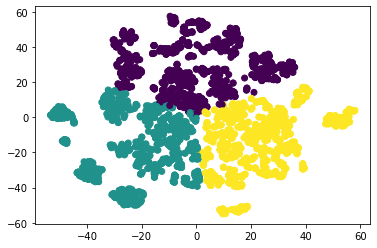

In [12]:
from sklearn.cluster import KMeans

kmins = KMeans(n_clusters=3, random_state=42, max_iter=50)
labels_train = kmins.fit_predict(X_train_tsne)
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=labels_train)
plt.show()

**Уменьшение размерности с 21 до 2 тестовых данных**

In [13]:
tsne = TSNE(n_components=2, learning_rate=20, random_state=42)

X_test_tsne = None
X_test_tsne = tsne.fit_transform(X_test)

print('До:\t{}'.format(X_test.shape))
print('После:\t{}'.format(X_test_tsne.shape))

До:	(5000, 22)
После:	(5000, 2)


**Построение диаграммы распределения для тренировочной модели**

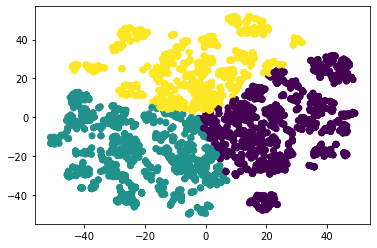

In [14]:
labels_train = kmins.fit_predict(X_test_tsne)
plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=labels_train)
plt.show()